## Problem Statement 1
Analyse the given restaurant data having user reviews and other information of restaurants. Perform an EDA to find out useful insights to improve overall restaurant experience in Bengaluru.

In [1279]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re, string, unicodedata
import nltk
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

%matplotlib inline
pd.options.display.max_rows = 3000

In [1280]:
# Load Data
restaurant_df = pd.read_csv("../data/RestoInfo.csv",encoding="UTF-8")

In [1281]:
# Let's peek into dataset
restaurant_df.head(10)

,Unnamed: 0,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,46019,Unique Brew Cafe Resto,No,No,NaN,0,Indiranagar,Quick Bites,NaN,Fast Food,200,[],[],Dine-out,Old Airport Road
1,28849,Jayanthi Sagar,No,No,3.1 /5,21,Koramangala 5th Block,Quick Bites,NaN,"South Indian, North Indian, Chinese",200,"[('Rated 2.0', ""RATEDn Works only because it'...",[],Dine-out,Koramangala 4th Block
2,19855,Rock Stone Ice Cream Factory,Yes,No,4.0/5,131,BTM,Dessert Parlor,"Icecream Cake, Brownie, Waffles, Chocolate Ice...",Ice Cream,230,"[('Rated 4.0', ""RATEDn Ice creams are really ...","['Midnight Indulgence Cake', 'Butterscotch Mel...",Delivery,Jayanagar
3,35188,Punjabi by Nature 2.0,No,No,4.2 /5,3236,BTM,"Casual Dining, Microbrewery","Paneer Tikki, Mutton Raan, Mango Margarita, Cr...",North Indian,NaN,"[('Rated 3.0', ""RATEDn It has a beautiful amb...",[],Delivery,Koramangala 7th Block
4,7070,Rayalaseema Chefs,Yes,Yes,3.9/5,225,Marathahalli,Casual Dining,"Bamboo Chicken, Butter Naan, Mutton Biryani, P...","North Indian, Biryani, Andhra, Chinese",800,"[('Rated 5.0', 'RATEDn Had Good experience wi...",[],Delivery,Brookefield
5,32050,Bistro Oui,Yes,Yes,4.1 /5,402,Koramangala 5th Block,"Cafe, Bar","Veg Burger, Pork Ribs, Pizza, Chicken Sandwich...","Cafe, Continental, Salad, Steak","1,200","[('Rated 4.0', 'RATEDn Funny & TastynnWe visi...",[],Pubs and bars,Koramangala 5th Block
6,9918,Bhavani Upahara,Yes,No,3.3/5,9,Bannerghatta Road,Quick Bites,NaN,South Indian,250,"[('Rated 5.0', 'RATEDn best north Karnataka f...",[],Delivery,BTM
7,6134,Hotel Tom's Restaurant,Yes,Yes,4.4/5,712,Richmond Road,Casual Dining,"Appam, Sea Food, Fry Prawns, Dal Fry, Chicken ...","Mangalorean, Seafood, Chinese, North Indian","1,000","[('Rated 4.0', ""RATEDn Quite an old place to ...",[],Dine-out,Brigade Road
8,5350,Munchies,Yes,No,3.9/5,64,Brigade Road,"Quick Bites, Bakery","Burgers, Sandwiches, Momos, Chicken Seekh Roll...","Fast Food, Bakery",250,"[('Rated 4.0', 'RATEDn I am glad i found this...","['Spicy Mixed Vegetable Club Sandwich', 'Chick...",Delivery,Brigade Road
9,2301,Vinaya Coffee Moments,Yes,No,3.8/5,46,JP Nagar,Cafe,"Filter Coffee, Pizza, Pasta","Burger, Cafe, Desserts, Sandwich, Italian",450,"[('Rated 3.0', ""RATEDn This is great place fo...",[],Dine-out,Bannerghatta Road


In [1282]:
# Check some more information about the dataset
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   2069 non-null   int64 
 1   name                         2069 non-null   object
 2   online_order                 2069 non-null   object
 3   book_table                   2069 non-null   object
 4   rate                         1770 non-null   object
 5   votes                        2069 non-null   int64 
 6   location                     2069 non-null   object
 7   rest_type                    2052 non-null   object
 8   dish_liked                   962 non-null    object
 9   cuisines                     2069 non-null   object
 10  approx_cost(for two people)  2053 non-null   object
 11  reviews_list                 2069 non-null   object
 12  menu_item                    2069 non-null   object
 13  listed_in(type)              2069

Great! The dataset looks good but need some preprocessing and cleaning. There are missing values in few columns (rate, rest_type, dish_liked, etc.) will check that in detail later.

But firstly we will rename the first column ('Unnamed 0'). Let's dig deeper into this column and see what it could be.

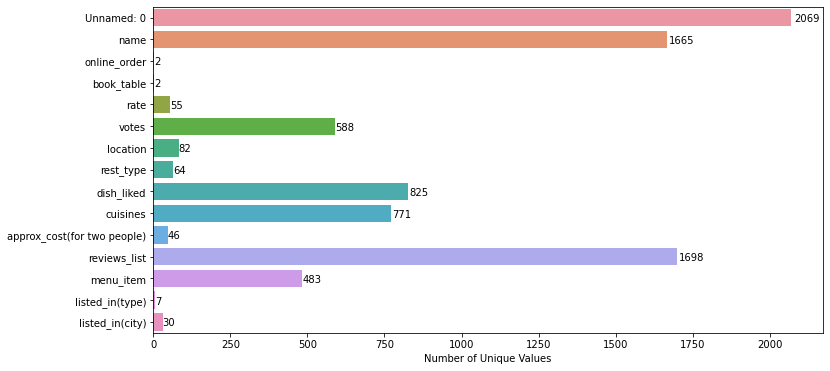

In [1283]:
# Check the number of unique values in each column
distinct_values = restaurant_df.nunique().reset_index()
distinct_values.columns = ['variable','distinct_value_count']
plt.figure(figsize=(12,6))
ax = sns.barplot(y='variable', x='distinct_value_count', data=distinct_values, orient='h')
plt.xlabel('Number of Unique Values')
plt.ylabel('')
for p in ax.patches:
    width = p.get_width()
    ax.annotate('{:1.0f}'.format(width), ((p.get_x() + p.get_width())*1.005, p.get_y()+0.55*p.get_height()),ha='left',va='center')

It is clear from the above plot that 'Unnamed: 0' has different value for each record, so it must be the ID column. 

One more thing to notice here that Name feature have overlapping values which means there are multiple records for the same restaurants. This tells us that there might be chain of restaurants at different location with same name or may the dataset has duplicate entries.

In [1284]:
# Let's Rename the columns
restaurant_df = restaurant_df.rename({'Unnamed: 0':'id', 'approx_cost(for two people)':'cost_for_two', 
                                      'rate':'aggregate_rating', 'approx_cost(for two people)':'cost_for_two',
                                     'listed_in(type)':'category', 'listed_in(city)':'city'},axis=1)

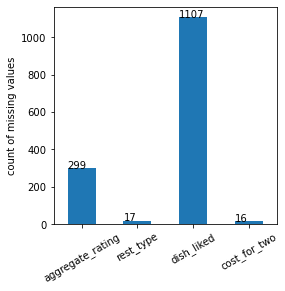

In [1285]:
# Check the missing values
missing_values = restaurant_df.isnull().sum()
plt.figure(figsize=(4,4))
ax1 = missing_values[missing_values!=0].plot.bar(rot=30)
plt.ylabel("count of missing values")
for p in ax1.patches:
    ax1.annotate(p.get_height(),(p.get_x(), p.get_height()))

In [1286]:
# Check for duplicate records
restaurant_df.duplicated().sum()

0

Let's compare the missing values of 'rate' column with respect to 'reviews_list'. If there is no entry in 'reviews_list' as well than we can drop those records.

It is clear that out of 299 missing values of 'rate' column, there are records does have values in 'reviews_list'. So we can calculate the average rating for these records using reviews and drop the remaining records. 

In [1287]:
# drop records
restaurant_df = restaurant_df[restaurant_df['aggregate_rating'].notnull()]

Let's apply some preprocessing and clean the dataset

In [1288]:
# Convert the text data to lowercase
restaurant_df['name'] = restaurant_df['name'].str.lower()
restaurant_df['location'] = restaurant_df['location'].str.lower()
restaurant_df['rest_type'] = restaurant_df['rest_type'].str.lower()
restaurant_df['dish_liked'] = restaurant_df['dish_liked'].str.lower()
restaurant_df['cuisines'] = restaurant_df['cuisines'].str.lower()
restaurant_df['menu_item'] = restaurant_df['menu_item'].str.lower()
restaurant_df['city'] = restaurant_df['city'].str.lower()

In [1289]:
# Remove special characters and punctuation
restaurant_df['rest_type'] = restaurant_df['rest_type'].str.replace("'|\[|\]",'')#(",|'|\[|\]",'')    # this code removes replace comma, square bracket and quotes with space
restaurant_df['menu_item'] = restaurant_df['menu_item'].str.replace("'|\[|\]",'')#(",|'|\[|\]",'')
restaurant_df['menu_item'] = restaurant_df['menu_item'].str.replace(r'^\s*$','not specified')
restaurant_df['dish_liked'] = restaurant_df['dish_liked'].str.replace("'|\[|\]",'')#(",|'|\[|\]",'')
restaurant_df['cuisines'] = restaurant_df['cuisines'].str.replace("'|\[|\]",'')#(",|'|\[|\]",'')
restaurant_df['cost_for_two'] = restaurant_df['cost_for_two'].str.replace(",",'').astype(float)
restaurant_df['aggregate_rating'] = restaurant_df['aggregate_rating'].str.replace("\/5",'')

Apply feature Engineering on reviews_list column and create some new columns

In [1290]:
def rating_type(rating):
    """Assign category to each rating"""
    if rating>=3.5:
        return 'good'
    elif rating>=2.0:
        return 'average'
    else:
        return 'bad'

# Extract rating from reviews as a list
restaurant_df['rating_list'] = restaurant_df['reviews_list'].str.findall(r"(?:'Rated )(\d+\.\d)")

# Convert rating list to float from string
restaurant_df['rating_list'] = restaurant_df['rating_list'].apply(lambda x: list(map(float, x)))

# Assign category to each rating in the list
restaurant_df['rating_list'] =restaurant_df['rating_list'].apply(lambda x: list(map(rating_type, x)))

# Count each type of rating and form a dictionary for each record
restaurant_df['rating_list'] = restaurant_df['rating_list'].apply(lambda x: {b:x.count(b) for b in x})

# Split this dictionary to separate column and concatenate to the dataframe
restaurant_df = pd.concat([restaurant_df,restaurant_df['rating_list'].apply(pd.Series)], axis = 1)

In [1291]:
# Let's do some calculation and find the percentage of good, average and bad reviews
# fill NaN with 0
str_cols = ['good','average','bad']
restaurant_df[str_cols] = restaurant_df[str_cols].fillna(0)

# Convert these three columns to int
restaurant_df[str_cols] = restaurant_df[str_cols].astype(int)

# Add these three columns and create a new column for total rating count
restaurant_df['number_of_reviews']=restaurant_df['average']+restaurant_df['good']+restaurant_df['bad']

# Convert to these rating count to percentage
restaurant_df[str_cols] = restaurant_df[str_cols].apply(lambda x: round(x/restaurant_df['number_of_reviews']*100,2))

# Again fill NaN with 0
restaurant_df[str_cols] = restaurant_df[str_cols].fillna(0)

# Rename the column
restaurant_df = restaurant_df.rename({'average':'neutral_reviews_percentage', 'good':'positive_reviews_percentage', 'bad':'negative_reviews_percentage'},axis=1)

In [1292]:
# Clean reviews_list column
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', '', text).strip('[]')

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('UTF-8', 'ignore') #ISO-8859-1
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.append('rated')
stopword_list.append('ratedn')
stopword_list.append('specified')


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words



def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas


In [1293]:
def normalize_and_lemmaize(input):
    sample = denoise_text(input)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    words = lemmatize(words)
    
    return ' '.join(words)

In [1294]:
restaurant_df['cleaned_reviews'] = restaurant_df['reviews_list'].map(lambda text: normalize_and_lemmaize(text))

In [1297]:
restaurant_df.sample()

,id,name,online_order,book_table,aggregate_rating,votes,location,rest_type,dish_liked,cuisines,...,reviews_list,menu_item,category,city,rating_list,neutral_reviews_percentage,positive_reviews_percentage,negative_reviews_percentage,number_of_reviews,cleaned_reviews
435,11244,flavour of himalaya,Yes,No,3.7,24,koramangala 5th block,quick bites,NaN,asian,...,"[('Rated 5.0', 'RATEDn Amazing food, amazing ...",not specified,Dine-out,btm,{'good': 1},0.0,100.0,0.0,1,amaze food amaze quantity nice peaceful setup ...


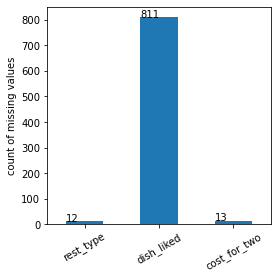

In [1298]:
# Again Check the missing values
missing_values = restaurant_df.isnull().sum()
plt.figure(figsize=(4,4))
ax1 = missing_values[missing_values!=0].plot.bar(rot=30)
plt.ylabel("count of missing values")
for p in ax1.patches:
    ax1.annotate(p.get_height(),(p.get_x(), p.get_height()))

In [1299]:
# mark NaN of rest_type as unspecified
restaurant_df['rest_type'] = restaurant_df['rest_type'].fillna('not specified')
restaurant_df['dish_liked'] = restaurant_df['dish_liked'].fillna('not specified')

# Drop records with missing values
restaurant_df = restaurant_df[restaurant_df['cost_for_two'].notnull()]

In [1300]:
# copy dataframe
cleaned_df = restaurant_df[restaurant_df['aggregate_rating']!='NEW'].copy()
cleaned_df.aggregate_rating = cleaned_df.aggregate_rating.astype(float)

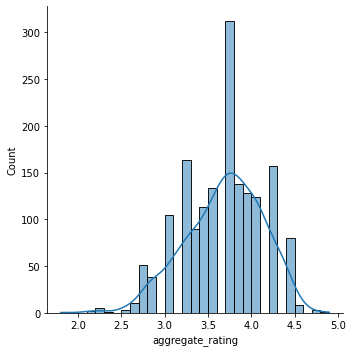

In [1302]:
# Plot distribution of aggregate rating
sns.displot(x=cleaned_df['aggregate_rating'], kde=True)
plt.show()

So, we have very good quality restaurant in bangalore, as most of the restaurant have been rated between the range from 3 to 4.5

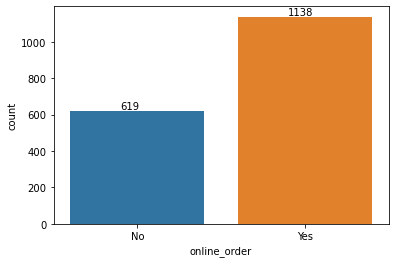

In [1303]:
# Check online order availability
ax2 = sns.countplot(x = restaurant_df.online_order)
for p in ax2.patches:
    ax2.annotate(p.get_height(),(p.get_x()+0.3, p.get_height()+10))

Approximately 75% of the restaurant deliver online

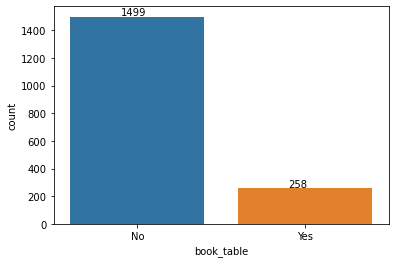

In [1304]:
# Let's check how many restaurant have booking option
ax3 = sns.countplot(x=restaurant_df['book_table'])
for p in ax3.patches:
    ax3.annotate(p.get_height(),(p.get_x()+0.3, p.get_height()+10))

So around 85% of the restaurants doesn't have table booking facility.

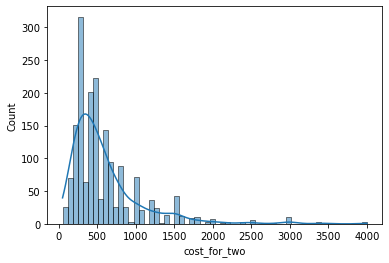

In [1306]:
# Now let's check how budget friendly the restaurant are
sns.histplot(restaurant_df.cost_for_two, kde=True)
plt.show()

Majority restaurants are pocket friendly and have average cost below 1000 for 2 people. There are around only 75 restaurant which has the cost between 1500 and 4000

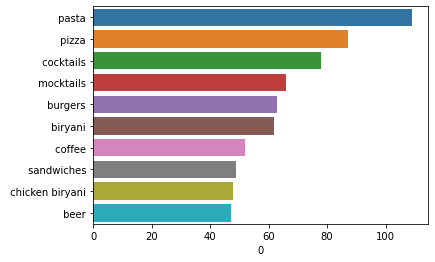

In [1335]:
# Let's checkout top 10 favourite food of Bangaloreans
dish_liked=restaurant_df.loc[restaurant_df['dish_liked']!='not specified','dish_liked']
import re
likes=[]
for dish in dish_liked:
    splited_array=re.split(',',dish)
    for item in splited_array:
        likes.append(item)

sns.barplot(x=pd.DataFrame(likes)[0].value_counts().head(10),y=pd.DataFrame(likes)[0].value_counts().head(10).index,orient='h')
plt.show()


Pasta, Pizza, Cocktails, Mocktails, Burgers, Biryani and Coffee are most liked food in Bangalore

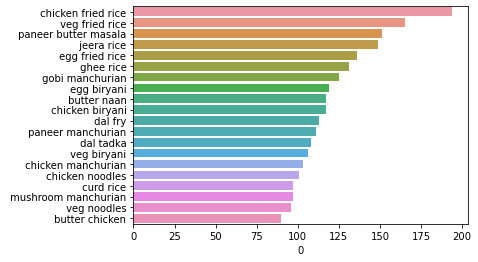

In [1337]:
# Let's checkout top 20 food items served by restaurant in Bangalore
menu_item=cleaned_df.loc[cleaned_df['menu_item']!='not specified','menu_item']
import re
menu=[]
for items in menu_item:
    splited_array=re.split(',',items)
    for item in splited_array:
        menu.append(item)

sns.barplot(x=pd.DataFrame(menu)[0].value_counts().head(20),y=pd.DataFrame(menu)[0].value_counts().head(20).index,orient='h')
plt.show()


Quite interesting numbers! Most of the restaurant serve different variety of fried and other type of rice, but most favourite food item among Bangaloreans are Pasta, Pizza, Cocktails, Mocktails and Burgers. 

So including these favourite food items in their menu might increase their number of customers.

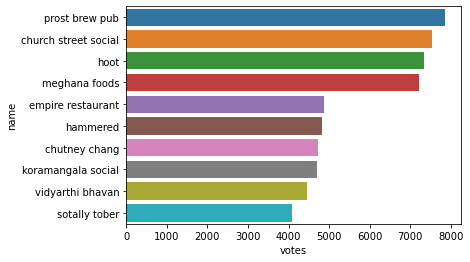

In [1368]:
# Most voted restaurants
y = cleaned_df.sort_values('votes',ascending=False)[['name','votes']].drop_duplicates()['name'].head(10)
x = cleaned_df.sort_values('votes',ascending=False)[['name','votes']].drop_duplicates()['votes'].head(10)
sns.barplot(x=x,y=y)
plt.show()

Post Brew Pub, Church Street Social, Hoot and Meghana Foods, hammered, chutney chang, koramangala social, vidyarthi bhavan, sotally tober are most visited restaurants

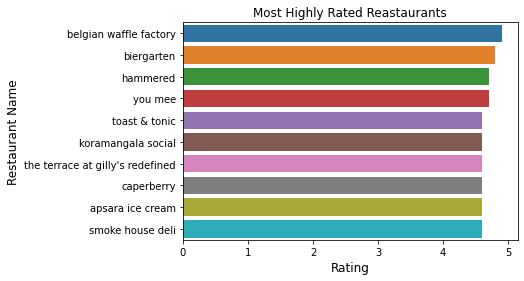

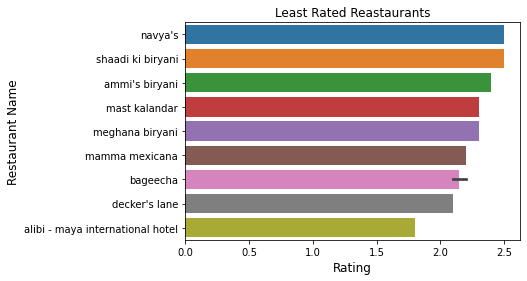

In [1352]:
# Most highly rated and least restaurants
y_rating = cleaned_df.sort_values('aggregate_rating',ascending=False)[['name','aggregate_rating']].drop_duplicates()['name']
x_rating = cleaned_df.sort_values('aggregate_rating',ascending=False)[['name','aggregate_rating']].drop_duplicates()['aggregate_rating']
sns.barplot(x=x_rating.head(10),y=y_rating.head(10))
plt.title('Most Highly Rated Reastaurants')
plt.ylabel('Restaurant Name',fontsize=12)
plt.xlabel('Rating',fontsize=12)
plt.show()
sns.barplot(x=x_rating.tail(10),y=y_rating.tail(10))
plt.title('Least Rated Reastaurants')
plt.ylabel('Restaurant Name',fontsize=12)
plt.xlabel('Rating',fontsize=12)
plt.show()

Belgian waffle factory, biergarten, hammered, you mee, toast & tonic, koramangala social, the terrace at gilly's redefined, caperberry, apsara ice cream and smoke house deli are highly rated restaurants.

Navya's, shaadi ki biryani, ammi's biryani, mast kalandar, meghana biryani, mamma mexicana, bageecha, decker's lane, bageecha, alibi - maya international hotel are least rated restaurants.

Considering only rating is not the right measure of popularity, as there may be the case where one restaurant is rated 5 by few customers and another rated 4.8 by many customers.

So which one is better, the obivious choice is second restaurant. Thus, we need to calculate weighted rating using rating and number of votes.

To calculated weighted rating we will use weight factor and penalize rating with the formula

###### weighted_rating = weight_factor * aggregate_rating 
where,

weight_factor is the total number of votes for any restaurant divided by max number of votes in whole dataset (i.e. votes/max_votes)

aggregate_rating is the average rating for the restaurant


In [1353]:
# Calculating new metric of popularity
max_votes = cleaned_df['votes'].max()

def weighted_rating(row):
    weighted_factor = row['votes']/max_votes
    return ((weighted_factor*row['aggregate_rating']))
    
cleaned_df['popularity_score'] = cleaned_df.apply(weighted_rating,axis=1)

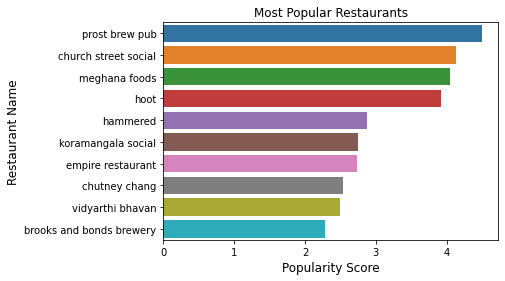

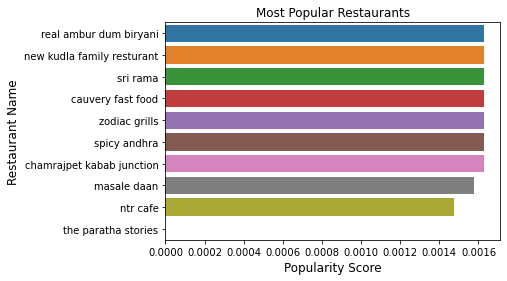

In [1360]:
# Top 10 most and least popular restaurants in Bangalore
popularity  = cleaned_df.sort_values('popularity_score', ascending=False)[['name','popularity_score','votes','aggregate_rating']].drop_duplicates().copy()
sns.barplot(x=popularity.head(10)['popularity_score'],y=popularity.head(10)['name'])
plt.title('Most Popular Restaurants')
plt.xlabel('Popularity Score',fontsize=12)
plt.ylabel('Restaurant Name',fontsize=12)
plt.show()
sns.barplot(x=popularity.tail(10)['popularity_score'],y=popularity.tail(10)['name'])
plt.title('Most Popular Restaurants')
plt.xlabel('Popularity Score',fontsize=12)
plt.ylabel('Restaurant Name',fontsize=12)
plt.show()


Yes, there is difference between the top 10 restaurants based on only rating and top 10 based on overall popularity score. The latter one is more accurate, and Prost Brew Pub, Church Street Social, Meghana Foods, Hoot, Hammered, Koramangala Social are most popular restaurants.

Also, there is some relation between number of votes and popularity of restaurants, as the top 5 most voted and top 5 most popular restaurants are same.

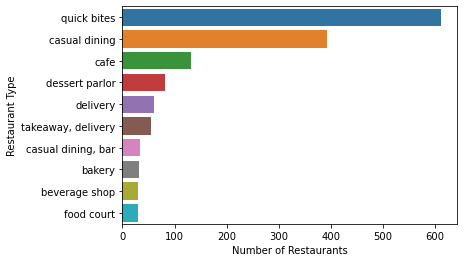

In [1317]:
# Check the type of restaurants available in bangalore
x=restaurant_df['rest_type'].value_counts().head(10)
y=restaurant_df['rest_type'].value_counts().head(10).index
sns.barplot(x=x,y=y)
plt.xlabel('Number of Restaurants')
plt.ylabel('Restaurant Type')
plt.show()

Majority of the Bangalore restaurants are Quick Bites and Casual Dining type. 

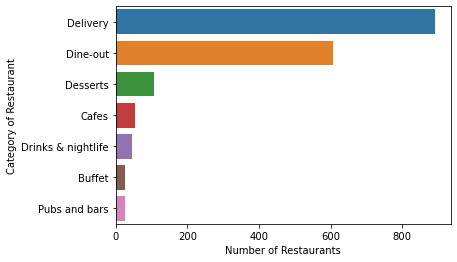

In [1318]:
# Let's Check under what category most of the restaurnts are listed
x=restaurant_df['category'].value_counts()
y=restaurant_df['category'].value_counts().index
sns.barplot(x=x,y=y)
plt.xlabel('Number of Restaurants')
plt.ylabel('Category of Restaurant')
plt.show()

There are many option available for Delivery and Dine Out, but very few for Nightlife, Buffet, Cafes, Pubs and bars. Thus it will be good idea to open restaurants of these categories with the help further research about demand and locality.

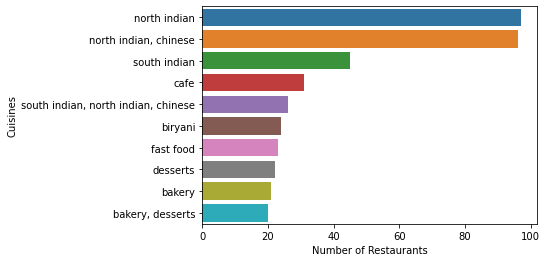

In [1319]:
# Check type of Cuisines in Bangalore
x=restaurant_df['cuisines'].value_counts().head(10)
y=restaurant_df['cuisines'].value_counts().head(10).index
sns.barplot(x=x,y=y)
plt.xlabel('Number of Restaurants')
plt.ylabel('Cuisines')
plt.show()

Thare are many food varieties available in Bangalore, but majority of the restaurant serve North Indian, South Indian and Chinese.

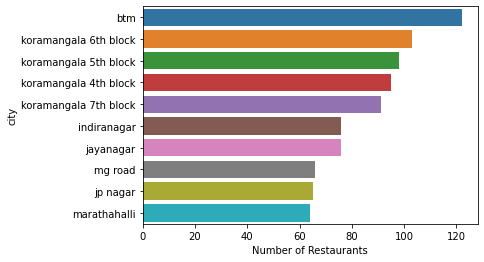

In [1321]:
# Let's check out which area has most number of restaurant
x=restaurant_df['city'].value_counts().head(10)
y=restaurant_df['city'].value_counts().head(10).index
sns.barplot(x=x,y=y)
plt.xlabel('Number of Restaurants')
plt.ylabel('city')
plt.show()

BTM and Koramangala mostly dominate in terms of restaurant. Let's see what speciality each area has

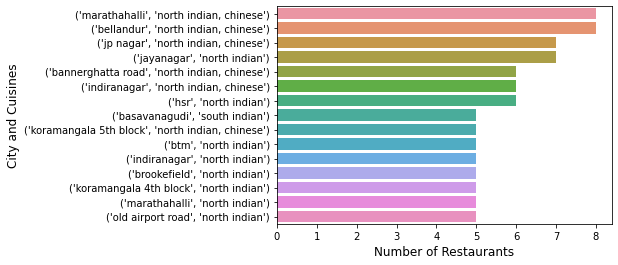

In [1322]:
# Explore area wise food speciality
areas_speciality = cleaned_df[['city','cuisines']].value_counts().head(15)
sns.barplot(x=areas_speciality,y=areas_speciality.index.values)
plt.ylabel('City and Cuisines', fontsize=12)
plt.xlabel('Number of Restaurants', fontsize=12)

plt.show()

From above plot it is clear that no area specialises in any one kind of food, we can get all variety in each locality and North Indian, Chinese are most common in all localities.

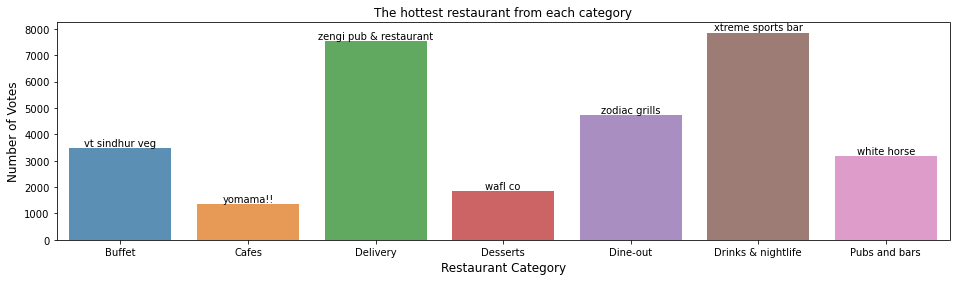

In [1373]:
#For each category of restaurant, suggest the 'hottest' restaurant that received the most votes
hot=restaurant_df[['name','votes','category']].groupby('category').max()
hot
plt.figure(figsize=(16,4))
ax = sns.barplot(x=hot.index.values, y=hot['votes'], alpha=0.8)
plt.title("The hottest restaurant from each category",fontsize=12)
locs, labels = plt.xticks()
#plt.setp(labels, rotation=20)
plt.ylabel('Number of Votes', fontsize=12)
plt.xlabel('Restaurant Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = hot['name']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

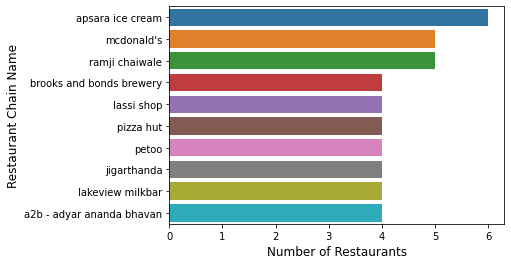

In [1324]:
# Lets check major restaurant group 
x=restaurant_df['name'].value_counts().head(10)
y=restaurant_df['name'].value_counts().head(10).index
sns.barplot(x=x,y=y)
plt.xlabel('Number of Restaurants',fontsize=12)
plt.ylabel('Restaurant Chain Name',fontsize=12)
plt.show()

Apsara ice cream, mcdonald's, ramji chaiwale, brooks and bonds brewery, lassi shop, pizza hut, petoo, jigarthanda, lakeview milkbar, a2b - adyar ananda bhavan are major chain restaurants available in Bangalore

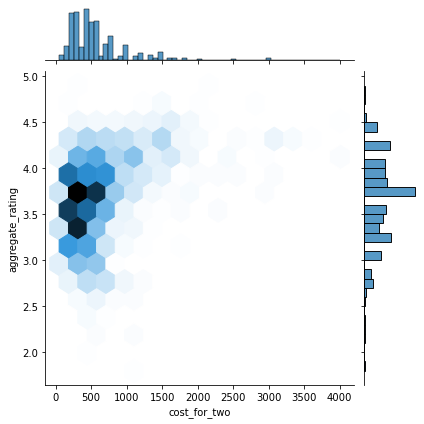

In [1325]:
# let's check whether our rating depend on cost or not
sns.jointplot(x='cost_for_two',y='aggregate_rating',data=cleaned_df,kind='hex',gridsize=15)
plt.show()

There is not much dependency, however we don't have any lower rating in restaurant with average cost more than 1500. This means that most of the costly restaurant take good care of their food and service

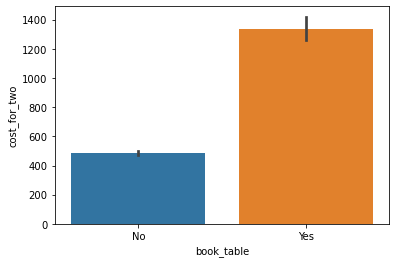

In [1326]:
# Whether table booking facility dependent on average cost?
x = cleaned_df.groupby('book_table')['cost_for_two'].mean()
sns.barplot(x=cleaned_df['book_table'],y=cleaned_df['cost_for_two'])
plt.show()

Yes! the costlier restaurants mostly have table booking facility.

# Problem Statement 2

Build a recommendation system, where user should be able to express what he wants and system should recommend relevant restaurants, to his liking.
<pre>
Requirements
    Recommend top 3 restaurant names based on these 4 input parameters
    User’s descriptive ordering information, as free text input. (e.g: good ambiance restaurant, serving fish)
    Location
    Budget
    Cuisine = e.g: Continental/Indian/Japanese etc.
    Restaurant Reviews (given in data) should not only be solely considered for implementing the solution. 

Example Input
    User Feels like (text) = good ambiance restaurants, serving fish  
    Location = Koramangala
    budget = 500 
    cuisine_type = North Indian

Output
    Restaurant 1 (90% likely) 
    Restaurant 2 (84% likely) 
    Restaurant 3 (81.5% likely)
</pre>

In [1327]:
# Combine text from columns and normalize
cleaned_df['text'] = cleaned_df[['name','rest_type', 'dish_liked','menu_item', 'category' ]].agg(' '.join, axis=1)
cleaned_df['text'] = cleaned_df['text'].map(lambda text: normalize_and_lemmaize(text))
cleaned_df['text'] = cleaned_df[['text','cleaned_reviews']].agg(' '.join, axis=1)

In [1277]:
# Take use input
user_text = input("Type your prefernces : ")
location = input("Location you want to be served : ").lower()
budget = input("Your Maximum Budget : ")
cuisine_type = input("Cuisines Type : ").lower()

Type your prefernces : good ambiance restaurants, serving fish
Location you want to be served : btm
Your Maximum Budget : 500
Cuisines Type : chinese


In [1375]:
# Function for restaurant recommendation based on user preference using cosine similarity
def get_recommendation(user_text,location,budget,cuisine_type,recommendation_count=3):
    user_text = [normalize_and_lemmaize(user_text)]
    
    filtered_df = cleaned_df.copy()
    
    # Filter restaurants based on location
    if len(location)>0:
        filtered_df = filtered_df[filtered_df['location'].str.contains(location)]
    
    
    # Filter restaurants based on budget
    if len(budget)>0:
        filtered_df = filtered_df[filtered_df['cost_for_two']<=float(budget)]
    
    # Filter restaurants based on cuisine type
    if len(cuisine_type)>0:
        filtered_df = filtered_df[filtered_df['cuisines'].str.contains(cuisine_type)]
    
    # Initialize Vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # make tfidf matrix for combined text 
    tfidf_text = tfidf_vectorizer.fit_transform((filtered_df['text'])) #fitting and transforming the vector
    
    # make tfidf matrix for user input text
    user_tfidf = tfidf_vectorizer.transform(user_text)
    
    # calculate similarity score using cosine similarity
    cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_text)
    sim_scores = list(cos_similarity_tfidf)
    list_scores = [sim_scores[i][0][0] for i in range(len(sim_scores))]
    filtered_df['similarity_score']=list_scores
    
    # Recommend top n restaurant using similarity_score followed by popularity_score
    recommendations = filtered_df.sort_values(['similarity_score', 'popularity_score'], ascending=[False, False])
    
    return (recommendations.head(recommendation_count)[['name','location','book_table', 'aggregate_rating', 'votes', 'location', 
                                                       'rest_type', 'dish_liked', 'cuisines', 'cost_for_two', 'menu_item', 
                                                       'neutral_reviews_percentage', 'positive_reviews_percentage',
                                                       'negative_reviews_percentage', 'number_of_reviews']])


get_recommendation(user_text,location,budget,cuisine_type,7)

,name,location,book_table,aggregate_rating,votes,location,rest_type,dish_liked,cuisines,cost_for_two,menu_item,neutral_reviews_percentage,positive_reviews_percentage,negative_reviews_percentage,number_of_reviews
1108,dev's gugababa,btm,No,3.5,177,btm,quick bites,"fish, rasmalai, doi katla, aalo bhaja, bhetki ...","bengali, north indian, chinese",500.0,not specified,25.00,25.00,50.00,4
1519,muthashy's,btm,No,4.2,470,btm,quick bites,"fish, appam, egg roast, kadala curry, chicken ...","kerala, south indian, chinese",400.0,"idly, masala dosa, kadala curry, egg curry, pa...",44.44,44.44,11.11,9
724,taste of malabar,btm,No,3.6,23,btm,quick bites,not specified,"south indian, kerala, chinese",350.0,not specified,100.00,0.00,0.00,1
1505,taste of malabar,btm,No,3.6,23,btm,quick bites,not specified,"south indian, kerala, chinese",350.0,not specified,100.00,0.00,0.00,1
1990,the bong palate,btm,No,3.8,63,btm,quick bites,"mutton kosha, basanti pulao, fish curry, chick...","bengali, north indian, chinese",300.0,"3 radhaballavi with cholar dal, 3 radhaballavi...",100.00,0.00,0.00,2
1249,rajveena kitchen,btm,No,3.7,28,btm,quick bites,not specified,"north indian, fast food, biryani, chinese",500.0,not specified,0.00,100.00,0.00,1
1957,amaravati,btm,No,3.6,39,btm,quick bites,not specified,"north indian, chinese",400.0,not specified,26.67,66.67,6.67,15


##### What can be done to improve recommendations?
* The count and percentage of positive, negative reviews can be used for better recommendation results.
* A more sophisticated formula like the Bayesian average can be used for calculating popularity score, as the used formula is biased towards the number of votes
* For better recommendations, more advance methods like word embeddings or CountVectorizer can be used  for encoding text to vector (or feature extraction)
